# Classification of Pneumonia X-rays and Benchmarking on Limited Hardware

The goal of this exercise is to classify chest x-rays into the following classes:

- Pneumonic
- Normal

The dataset consists of:  
  
- 5216 Training set photos
- 16 Validation set photos
- 624 Testing set photos  
  
Since the validation set is so small, I have concatenated these to the training set and subsequently performed a training-validation split of 80:20 on the concatenated set during training.  
  
For unsupervised learning, I have used Principal Components Analysis for visualization and analysis of dimensionality reduction, and t-Distributed Stochastic Neighbor Embedding for further visualization of clusters.

For supervised learning, I have chosen to use initially train a couple of classic machine learning algorithms such as Random Forests, Gradient Boosting, Logistic Regression and Support Vector Machines. Some of these models also let's us output feature importance and coefficient values which we can use to visualize the average relative importance of different features (e.g. pixels) in our examples. The results from these models will also serve as a baseline performace measure against our final model which will be a Convolutional Neural Network. 

As we will see, the dataset is unbalanced. (e.g. the number of positively and negatively classified photos are different within each set) I will therefore add the precision and recall values in addition to the accuracy metric in my measure of fit. The Area Under the Receiver Operating Characteristc Curve (AUC) will serve as a measure of flexibility within each model for adjusting our the decision boundary in case we wish to increase either precision or recall.

### Computational Load and Hardware Setup

This project was an experiement to see how effective we can make our models with the limited hardware we have a out disposal. I have therefore measured the computational time for each model's hyperparamenter grid search. Since the grid search process is embarassingly parallell, we can use the `n_jobs=-1` argument efficiently utilize all of our cores.
  
My hardware setup is as follows:  
  
- CPU: Intel(R) Core(TM) i5-6500 CPU @ 3.20GHz, 3201 Mhz, 4 Core(s), 4 Logical Processor(s)
- GPU: NVIDIA GeForce GTX 1060 3GB
- RAM: 16GB 2133 Mhz
- Disks: 1x 250GB SSD, 1x 1TB HD

## Downloading and Unzipping Files

In [1]:
import os
import kaggle

kaggle.api.authenticate()

path = "C:/Users/Andreas/Documents/Datasets/Pneumonia"

if not os.path.exists(path):
    os.makedirs(path)
    kaggle.api.dataset_download_files(
        "paultimothymooney/chest-xray-pneumonia", path=path, unzip=True)

Remove redundant folders, and check final directory tree:

In [2]:
import shutil

DIR = "C:/Users/Andreas/Documents/Datasets/Pneumonia/chest_xray"

if os.path.exists(os.path.join(DIR, "chest_xray")):
    shutil.rmtree(os.path.join(DIR, "chest_xray"))
    shutil.rmtree(os.path.join(DIR, "__MACOSX"))

for path, dirs, files in os.walk(DIR):
  print(path)

C:/Users/Andreas/Documents/Datasets/Pneumonia/chest_xray
C:/Users/Andreas/Documents/Datasets/Pneumonia/chest_xray\test
C:/Users/Andreas/Documents/Datasets/Pneumonia/chest_xray\test\NORMAL
C:/Users/Andreas/Documents/Datasets/Pneumonia/chest_xray\test\PNEUMONIA
C:/Users/Andreas/Documents/Datasets/Pneumonia/chest_xray\train
C:/Users/Andreas/Documents/Datasets/Pneumonia/chest_xray\train\NORMAL
C:/Users/Andreas/Documents/Datasets/Pneumonia/chest_xray\train\PNEUMONIA
C:/Users/Andreas/Documents/Datasets/Pneumonia/chest_xray\val
C:/Users/Andreas/Documents/Datasets/Pneumonia/chest_xray\val\NORMAL
C:/Users/Andreas/Documents/Datasets/Pneumonia/chest_xray\val\PNEUMONIA


**Dependencies:**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL

## Loading Data and Wrangling

Make a list of all file names, then join them into a list of file paths for each dataset.

In [4]:
path_dirs = ["train/NORMAL", "train/PNEUMONIA",
             "val/NORMAL", "val/PNEUMONIA",
             "test/NORMAL", "test/PNEUMONIA"]

(train_normal_files, train_pneumonia_files,
 valid_normal_files, valid_pneumonia_files,
 test_normal_files, test_pneumonia_files) = [
    [files for path, dirs, files in os.walk(os.path.join(DIR, path))][0] 
    for path in path_dirs]

set_files = [train_normal_files, train_pneumonia_files,
             valid_normal_files, valid_pneumonia_files,
             test_normal_files, test_pneumonia_files]

(train_normal_paths, train_pneumonia_paths,
 valid_normal_paths, valid_pneumonia_paths,
 test_normal_paths, test_pneumonia_paths) = [
    list(map(lambda x: os.path.join(
    DIR, path, x), files)) for path, files in zip(path_dirs, set_files)]

Checking the number of files in each list.  
  
As stated earlier, the dataset is imbalanced. (There are about 2.7 times more positively classified photos overall)

In [5]:
set_paths = [train_normal_paths, train_pneumonia_paths,
             valid_normal_paths, valid_pneumonia_paths,
             test_normal_paths, test_pneumonia_paths]

set_names = ["Train Normal", "Train Pneumonic",
             "Validation Normal", "Validation Pneumonic",
             "Test Normal", "Test Pneumonic"]

for i in range(len(set_paths)):
  print("{}: {}".format(set_names[i], len(set_paths[i])))

Train Normal: 1341
Train Pneumonic: 3875
Validation Normal: 8
Validation Pneumonic: 8
Test Normal: 234
Test Pneumonic: 390


Concatenating the paths of both classes for each dataset (the datasets will be shuffled before training), then the training set and validation set is concatenated.

In [6]:
train_set_paths = (train_normal_paths + train_pneumonia_paths 
                   + valid_normal_paths + valid_pneumonia_paths)

test_set_paths = test_normal_paths + test_pneumonia_paths

### Sample Images

Use the PILLOW package to import random images from directory, and create a subplot with a row of normal and pneumonic photos respectively. The tuple in the figure title indicate the dimensions of the photos. Since the dimensions are not uniform, we will need to resize them prior to training.  
  
Some of the photos are encoded in RGB, some in grayscale. (The photos appearing to be gray are RGB encoded, the photos mapped on the viridis scale are grayscale)

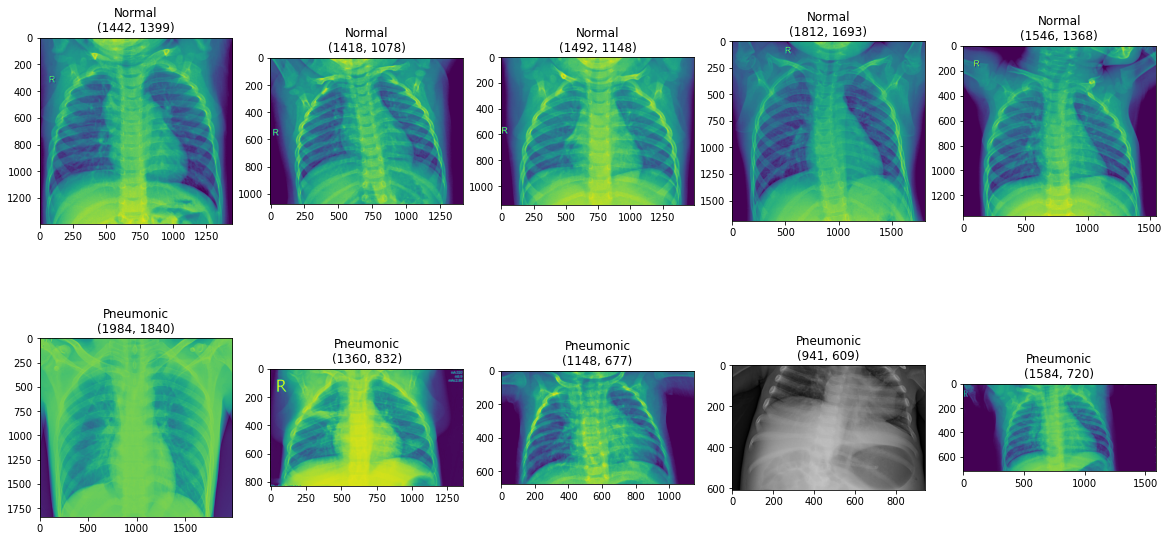

In [7]:
num_cols = 5

np.random.seed(3)
idx = np.random.randint(0, len(train_normal_paths), num_cols)

fig, ax = plt.subplots(2, num_cols, figsize=(20, 10))
axes = ax.ravel()

for i in range(len(idx)):
    axes[i].imshow(PIL.Image.open(train_normal_paths[idx[i]]))
    axes[i].set_title("Normal\n{}".format(
        PIL.Image.open(train_normal_paths[idx[i]]).size))
    axes[i+num_cols].imshow(PIL.Image.open(train_pneumonia_paths[idx[i]]))
    axes[i+num_cols].set_title("Pneumonic\n{}".format(
        PIL.Image.open(train_pneumonia_paths[idx[i]]).size))

### Importing and converting data

For our Random Forests and Logistic Regression classifiers, we will preprocess the photos with the followng steps:  
  
- Convert all photos to grayscale: `convert("L")`
- Resize all photos to 100 x 100: `resize((100, 100))`
- Convert the PILLOW-image object to a numpy array of shape: `[100, 100]`
- Ravel the resulting array into the shape: `[10000]`  
  
We will then store all the converted photos into two arrays with the shape: `[num_examples, 10000]`  
These files will be pickled for convenience. (We load pickled file if it exists, skipping this whole process)

In [8]:
import pickle

set_lengths = [len(train_set_paths), len(test_set_paths)]
save_path = os.path.join(DIR, "sets.p") 

if os.path.exists(save_path):
    sets = pickle.load(open(save_path, "rb"))
    
else:      
    # Initialize arrays
    train_set = np.zeros((set_lengths[0], 10000))
    test_set = np.zeros((set_lengths[1], 10000))

    paths = [train_set_paths, test_set_paths]
    sets = [train_set, test_set]

    for i in range(len(sets)):
        for j in range(set_lengths[i]):
            image = np.array(PIL.Image.open(
                paths[i][j]).convert("L").resize((100, 100))).ravel()
            sets[i][j, :] = image
    
    pickle.dump(sets, open(save_path, "wb"))

Create our target classification values, concatenate training and validation targets.

In [9]:
# Initialize target arrays
train_target = np.zeros((len(train_normal_paths) 
                         + len(train_pneumonia_paths)), dtype="int32")
valid_target = np.zeros((len(valid_normal_paths) 
                         + len(valid_pneumonia_paths)), dtype="int32")
test_target = np.zeros((len(test_normal_paths) 
                        + len(test_pneumonia_paths)), dtype="int32")

# Change the value to 1 for pneumonic examples
train_target[len(train_normal_paths):] = 1
valid_target[len(valid_normal_paths):] = 1
test_target[len(test_normal_paths):] = 1

train_target = np.hstack((train_target, valid_target))

In [10]:
print("Train set shape: {}".format(sets[0].shape))
print("Test set shape: {}".format(sets[1].shape))
print("Train target shape: {}".format(train_target.shape))
print("Test target shape: {}".format(test_target.shape))

Train set shape: (5232, 10000)
Test set shape: (624, 10000)
Train target shape: (5232,)
Test target shape: (624,)


Assigning standardized names to each array, then shuffle the examples:

In [11]:
X_train, X_test = (sets[0], sets[1])
y_train, y_test = (train_target, test_target)

In [12]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state = 0)
X_test, y_test = shuffle(X_test, y_test, random_state = 0)

# Unsupervised Learning

We will apply two types of unsupervised learning to see if there are possible patterns in the data that will let us separate the two classes during our supervised learning stage.

## Principal Components Analysis

The Principal Components Analysis (PCA) algorithm will attempt to find the axis through our 10000-dimension feature space that preserves the most of the variability in our dataset.  
  
I will primarily use this for visualization of the dataset, therefore I will reduce our dimensions to the first two principal components. Pattern differenes between our normal and pneumonic examples will indicate that there are features differences we can extract during feature extraction.

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42).fit(X_train)
X_train_transformed = pca.transform(X_train)

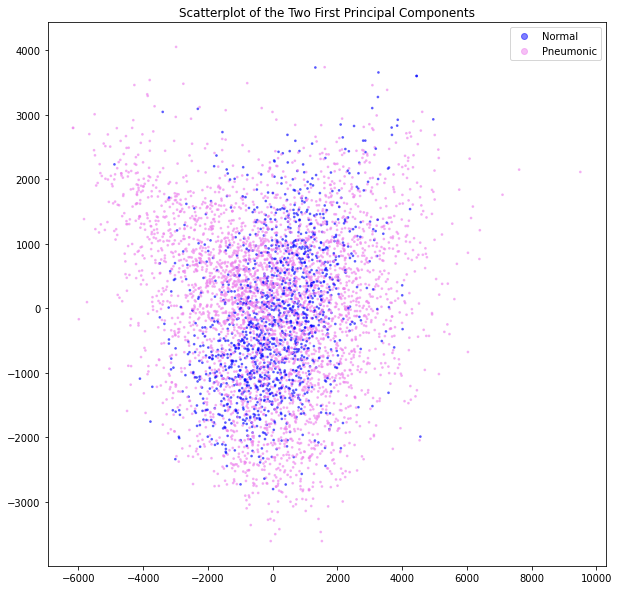

In [14]:
import matplotlib.colors

labels = ["Normal", "Pneumonic"]

plt.figure(figsize=(10, 10))

scatter = plt.scatter(
    X_train_transformed[:, 0], X_train_transformed[:, 1], 
    c=y_train, cmap=matplotlib.colors.ListedColormap(["blue", "violet"]),
    s=3, alpha=0.5, label=y_train)
plt.legend(handles=scatter.legend_elements()[0], labels=labels)
plt.title("Scatterplot of the Two First Principal Components")
plt.show()

We see that in general, the pneumonic examples in general have a higher spread in values compared to normal examples. This would indicate that our pneumonic examples tend to have higher positive values in more dimensions (e.g. in more pixels) compared to normal examples.

### Variance Explained

With PCA we can also identify the relationship between the number of features reduce to and the total variance explained.

In [15]:
pca = PCA(random_state=42).fit(X_train)

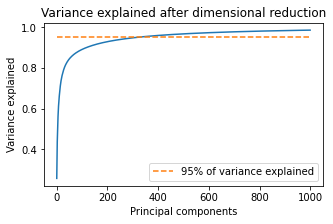

,Var. explained:,Principal components
0,0.800,30
1,0.900,117
2,0.950,316
3,0.975,645
4,0.990,1286


In [16]:
expl_cumsum = np.cumsum(pca.explained_variance_ratio_)[:1000]

plt.figure(figsize=(5, 3))
plt.plot(range(1000), expl_cumsum)
plt.plot([0, 1000], [0.95, 0.95], "--", label="95% of variance explained")
plt.legend()
plt.title("Variance explained after dimensional reduction")
plt.xlabel("Principal components")
plt.ylabel("Variance explained")

plt.show()

var_explained = [0.8, 0.9, 0.95, 0.975, 0.99]

pd.DataFrame({"Var. explained:": var_explained,
              "Principal components": [
                  np.argmin(np.abs(np.cumsum(
                      pca.explained_variance_ratio_) - ratio)) for ratio in var_explained]})

We see that we can keep 99% of the variance in our data while reducing our dimensionality to 1286-dimensions. This indicates that there are many features in our examples that have little information (e.g. many pixels that cannot be used for our classification task). We will utilize this result for computationally heavy algorthms later on.

## t-Distributed Stochastic Neighbor Embedding

The t-Distributed Stochastic Neighbor Embedding (t-SNE) algorithm excells in visualizing clusters in our dataset. Examples with similar features will be clustered together on the plot.

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE()
X_train_transformed = tsne.fit_transform(X_train)

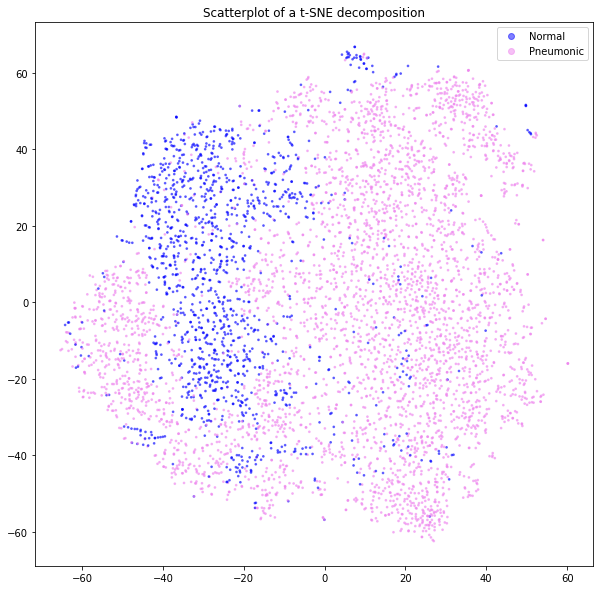

In [18]:
plt.figure(figsize=(10, 10))

scatter = plt.scatter(
    X_train_transformed[:, 0], X_train_transformed[:, 1], 
    c=y_train, cmap=matplotlib.colors.ListedColormap(["blue", "violet"]),
    s=3, alpha=0.5, label=y_train)
plt.legend(handles=scatter.legend_elements()[0], labels=labels)
plt.title("Scatterplot of a t-SNE decomposition")
plt.show()

Our t-SNE decomposition seems to group our normal exmples neatly together, but parts of the pneumonic examples are grouped opposite side of the main group (on the left). This could indicate the need for a flexible model that is able to classify dissimilar examples correctly.  
  
All in all though, this analysis seems to indicate a possible way to separate our classes along our dimensions.

# Supervised Learning

Due to limited computational capacity, I have performed a very basic grid search for each model.  
Ideally, the parameter grid should contain more hyperparameters.

Importing Pipeline utilities:

In [19]:
import time
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

Importing metrics:

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## Random Forest Classifier

In [119]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([("rf", RandomForestClassifier())])

param_grid = {"rf__n_estimators" : [100, 500, 1000],
              "rf__max_depth" : [5, 15, 25]}

time_start = time.perf_counter() 
grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
time_elapsed = (time.perf_counter() - time_start)

In [120]:
print("Time Elapsed:\n{} minutes\n".format(time_elapsed // 60))
print("Best parameters:\n{}\n".format(grid.best_params_))
print("Best validation accuracy score:\n{:.3f}".format(grid.best_score_))

Time Elapsed:
25.0 minutes

Best parameters:
{'rf__max_depth': 25, 'rf__n_estimators': 500}

Best validation accuracy score:
0.959


Fit final model using the optimal paramters:

In [23]:
model_rf = RandomForestClassifier(
    max_depth=25, n_estimators=500).fit(X_train, y_train)

### Model Performance

In [24]:
preds_rf = model_rf.predict(X_test)
probas_rf = model_rf.predict_proba(X_test)[:,1]

In [25]:
preds_rf = model_rf.predict(X_test)
probas_rf = model_rf.predict_proba(X_test)[:,1]

print("Accuracy: {:.3f}".format(accuracy_score(y_test, preds_rf)))
print("Precision: {:.3f}".format(precision_score(y_test, preds_rf)))
print("Recall: {:.3f}".format(recall_score(y_test, preds_rf)))
print("AUC: {:.3f}".format(roc_auc_score(y_test, probas_rf)))

Accuracy: 0.768
Precision: 0.732
Recall: 0.992
AUC: 0.936


We see that our Recall is much higher than our precision with the standard classification threshold of 0.5.
In other words, we are able to correctly classify our pneumoic examples correctly 99.2% of the time, but at the cost of misclassifying all of the examples predicted to be pneumonic 72.6% of the time.  
  
The AUC score will give an indication of relative flexibility in the model to adjust the threshold if we wish to improve either our precision or recall scores.

### Feature Importance

The below plot shows the relative importance of each feature (each pixel) within the Random Forest classifier.  
Darker colour indicates higher importance.

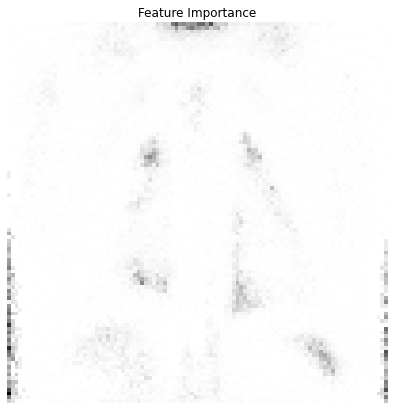

In [26]:
plt.figure(figsize=(7,7))
plt.imshow(model_rf.feature_importances_.reshape(100, 100), cmap="binary")
plt.axis("off")
plt.title("Feature Importance")
plt.show()

## Logistic Regression

To improve convergence, we first standardize our and scale our features with the `StandardScaler`. 
  
We perform a simple grid search along our regularizer parameter `C` as well as both the `L1` and `L2` reguralization norms.

In [121]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([("scaler", StandardScaler()),
                 ("lr", LogisticRegression(solver="lbfgs", max_iter=1000))])

param_grid = {"lr__C": [0.0001, 0.001, 0.01, 0.1, 1],
              "lr__penalty": ["l1", "l2"]}

time_start = time.perf_counter() 
grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
time_elapsed = (time.perf_counter() - time_start)

In [122]:
print("Time Elapsed:\n{} minutes\n".format(time_elapsed // 60))
print("Best parameters:\n{}\n".format(grid.best_params_))
print("Best validation accuracy score:\n{:.3f}".format(grid.best_score_))

Time Elapsed:
4.0 minutes

Best parameters:
{'lr__C': 0.01, 'lr__penalty': 'l2'}

Best validation accuracy score:
0.964


Fit final model using the optimal paramters, making sure to apply the same scale to our test set:

In [123]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
model_lr = LogisticRegression(solver="lbfgs", max_iter=1000, C=0.01, penalty="l2").fit(X_train_std, y_train)

X_test_std = scaler.transform(X_test)

### Model Performance

In [30]:
preds_lr = model_lr.predict(X_test_std)
probas_lr = model_lr.predict_proba(X_test_std)[:, 1]

In [31]:
print("Accuracy: {:.3f}".format(accuracy_score(y_test, preds_lr)))
print("Precision: {:.3f}".format(precision_score(y_test, preds_lr)))
print("Recall: {:.3f}".format(recall_score(y_test, preds_lr)))
print("AUC: {:.3f}".format(roc_auc_score(y_test, probas_lr)))

Accuracy: 0.747
Precision: 0.714
Recall: 0.992
AUC: 0.907


The Logistic Regression classifier performs better during cross validation, but slightly worse than the Random Forest classifier on the test set.

### Mapping Coefficients

The below plot shows the value of our feature coefficients. The pixels with a blue hue have negative coefficients (making a high pixel value predictive of a normal lungs), while pixels with a red hue have positive coefficients (making higher pixel value predictive of pneumonic lungs)

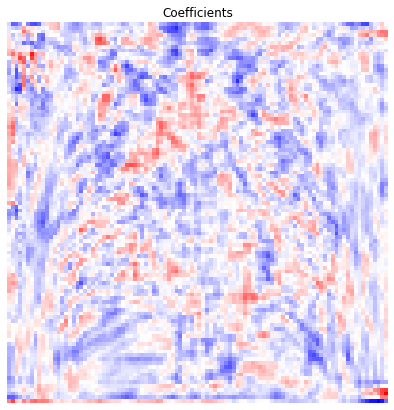

In [32]:
plt.figure(figsize=(7,7))
plt.imshow(model_lr.coef_.reshape(100, 100), cmap="bwr")
plt.axis("off")
plt.title("Coefficients")
plt.show()

As the photos are not vertically aligned to the spine in the same way, the image is difficult to interpret. However, on the center-left area of the picture we can see some blue diagonal patterns, with red areas in between. This would indicate that high values in the red areas (the gaps in the ribcage) would be multiplied with positive coefficients and thus increase the probability for a pneumonic classification of the example).  
  
High values around the upper part of the lung, especially on the left side of the picture, also seems to be an indicator of pneumonia.

## Gradient Boosting

As Gradient Boosting algorithms can be notoriously computationally taxing, we will first use our result from our Principal Components Analysis to reduce our dimensions while still preserving 99% of the variance. 

In [36]:
from sklearn.ensemble import GradientBoostingClassifier


pipe = Pipeline([("pca", PCA(n_components=1286, random_state=42)),
                 ("gb", GradientBoostingClassifier())])

param_grid = {"gb__max_depth": [1, 2],
              "gb__n_estimators": [100, 1000],
              "gb__learning_rate": [0.01, 0.1]}

time_start = time.perf_counter() 
grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
time_elapsed = (time_start - time.perf_counter())

In [41]:
print("Time Elapsed:\n{} minutes\n".format(time_elapsed // 60))
print("Best parameters:\n{}\n".format(grid.best_params_))
print("Best validation accuracy score:\n{:.3f}".format(grid.best_score_))

Time Elapsed:
123.0 minutes

Best parameters:
{'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__n_estimators': 1000}

Best validation accuracy score:
0.951


In [42]:
pca = PCA(n_components=1286, random_state=42).fit(X_train)
X_train_reduced = pca.transform(X_train)
model_gb = GradientBoostingClassifier(
    n_estimators=1000, learning_rate=0.1, max_depth=2).fit(X_train_reduced, y_train)

X_test_reduced = pca.transform(X_test)

### Model Performance

In [43]:
preds_gb = model_gb.predict(X_test_reduced)
probas_gb = model_gb.predict_proba(X_test_reduced)[:,1]

In [44]:
print("Accuracy: {:.3f}".format(accuracy_score(y_test, preds_gb)))
print("Precision: {:.3f}".format(precision_score(y_test, preds_gb)))
print("Recall: {:.3f}".format(recall_score(y_test, preds_gb)))
print("AUC: {:.3f}".format(roc_auc_score(y_test, probas_gb)))

Accuracy: 0.766
Precision: 0.731
Recall: 0.990
AUC: 0.928


### Feature Importance

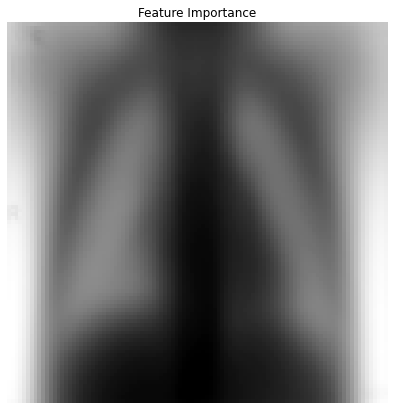

In [45]:
plt.figure(figsize=(7,7))
plt.imshow(pca.inverse_transform(model_gb.feature_importances_).reshape(100, 100), cmap="binary")
plt.axis("off")
plt.title("Feature Importance")
plt.show()

## Support Vector Machine

Since Support Vector Machines are highly sensitive to it's hyperparameters, let's spend some time fine tuning them iteratively.

In [46]:
from sklearn.svm import SVC

pipe = Pipeline([("pca", PCA(n_components=1286, random_state=42)),
                 ("scaler", StandardScaler()),
                 ("svm", SVC(probability=False))])

param_grid = {"svm__C": [1, 100, 100000],
              "svm__gamma": [0.001, 0.01, 0.1]}

time_start = time.perf_counter() 
grid = GridSearchCV(pipe, param_grid=param_grid,
                    cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
time_elapsed = (time.perf_counter() - time_start)

In [47]:
print("Time Elapsed:\n{} minutes\n".format(time_elapsed // 60))
print("Best parameters:\n{}\n".format(grid.best_params_))
print("Best validation accuracy score:\n{:.3f}".format(grid.best_score_))

Time Elapsed:
18.0 minutes

Best parameters:
{'svm__C': 100, 'svm__gamma': 0.001}

Best validation accuracy score:
0.896


In [49]:
param_grid = {"svm__C": [10, 100, 1000],
              "svm__gamma": [0.0001, 0.001, 0.1]}

time_start = time.perf_counter() 
grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
time_elapsed = (time.perf_counter() - time_start)

In [50]:
print("Time Elapsed:\n{} minutes\n".format(time_elapsed // 60))
print("Best parameters:\n{}\n".format(grid.best_params_))
print("Best validation accuracy score:\n{:.3f}".format(grid.best_score_))

Time Elapsed:
15.0 minutes

Best parameters:
{'svm__C': 10, 'svm__gamma': 0.0001}

Best validation accuracy score:
0.947


In [51]:
param_grid = {"svm__C": [0.1, 1, 10],
              "svm__gamma": [0.00001, 0.00033, 0.0001, 0.0033]}

time_start = time.perf_counter() 
grid = GridSearchCV(pipe, param_grid=param_grid, 
                    cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
time_elapsed = (time.perf_counter() - time_start)

In [52]:
print("Time Elapsed:\n{} minutes\n".format(time_elapsed // 60))
print("Best parameters:\n{}\n".format(grid.best_params_))
print("Best validation accuracy score:\n{:.3f}".format(grid.best_score_))

Time Elapsed:
19.0 minutes

Best parameters:
{'svm__C': 10, 'svm__gamma': 0.0001}

Best validation accuracy score:
0.947


In [53]:
pca = PCA(n_components=1286, random_state=42).fit(X_train)
X_train_reduced = pca.transform(X_train)
scaler = StandardScaler().fit(X_train_reduced)
X_train_std_reduced = scaler.transform(X_train_reduced)
model_svm = SVC(C=10, gamma=0.0001, probability=True).fit(X_train_std_reduced, y_train)

X_test_reduced = pca.transform(X_test)
X_test_std_reduced = scaler.transform(X_test_reduced)

### Model Performance

In [54]:
preds_svm = model_svm.predict(X_test_std_reduced)
probas_svm = model_svm.predict_proba(X_test_std_reduced)[:,1]

In [55]:
print("Accuracy: {:.3f}".format(accuracy_score(y_test, preds_svm)))
print("Precision: {:.3f}".format(precision_score(y_test, preds_svm)))
print("Recall: {:.3f}".format(recall_score(y_test, preds_svm)))
print("AUC: {:.3f}".format(roc_auc_score(y_test, probas_svm)))

Accuracy: 0.739
Precision: 0.709
Recall: 0.987
AUC: 0.876


## Receiver Operating Characteristic

Let us now compare the performances of our models so far.

In [56]:
model_names = ["Random Forest", "Gradient Boosting", "Logistic Regression", "Support Vector Machine"]
metric_names = ["Accuracy", "Precision", "Recall", "AUC"]
probas = [probas_rf, probas_gb, probas_lr, probas_svm]
preds = [preds_rf, preds_gb, preds_lr, preds_svm]
metrics = [accuracy_score, precision_score, recall_score]
colors = ["blue", "violet", "orange", "green"]

scores = [list(map(lambda x: metric(y_test, x), preds)) for metric in metrics]
scores.append(list(map(lambda x: roc_auc_score(y_test, x), probas)))
scores = np.transpose(scores)

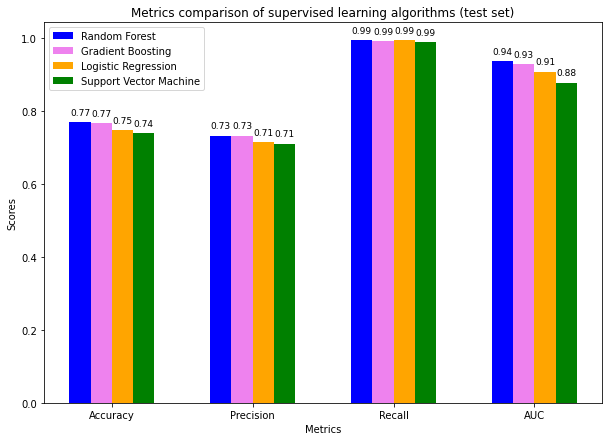

In [57]:
X = np.arange(4)

plt.figure(figsize=(10, 7))

for i in range(4):
    plt.bar(X + 0.15 * i, scores[i], color=colors[i], width=0.15, label=model_names[i])
    for j in range(4):
        plt.text((X[i] + 0.15 * j), scores[j][i] + 0.02, "{:.2f}".format(scores[j][i]), 
                 horizontalalignment='center', size=9)
        
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.title("Metrics comparison of supervised learning algorithms (test set)")
plt.xticks(np.arange(4) + 0.225, metric_names)
plt.legend()

plt.show()

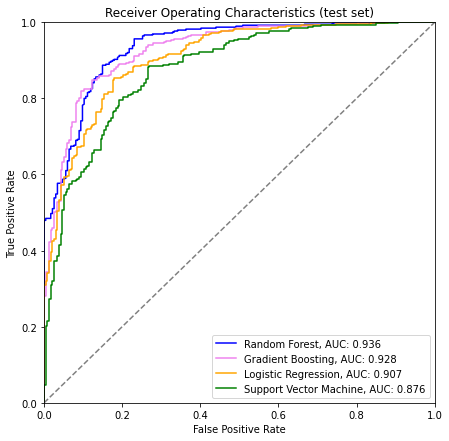

In [58]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(7,7))
plt.title("Receiver Operating Characteristics (test set)")

for i in range(4):
  fpr, tpr, threshold = roc_curve(y_test, probas[i])
  AUC = roc_auc_score(y_test, probas[i])
  lab = "{}, AUC: {:.3f}".format(model_names[i], AUC)
  plt.plot(fpr, tpr, c=colors[i], label = lab)
plt.legend()
plt.plot([0, 1], [0, 1], '--', c="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Convolutional Neural Networks

Convolutional Neural Networks (CNN) utilizes stacked convolutional layers which excell on analyzing spatial data. However, the sheer number of combinations of stacks and the way layers are configured makes such a model a daunting task to perform hyperparameter tuning on any environment, let alone one with limited resources such as ours.  
  
First of all, even semi-deep models are practically intractable to compute on without a GPU. Fortunately for us, we do have a GPU capable of performing the computation, but this brings us neatly to our second problem. Our GPU has only 3GB of RAM available, and this will become a bottleneck for us in two ways: First, this will limit the number of parameters in our model since they will need to be stored simultaneously in memory during training. Secondly, it will limit the number of examples we can load and handle simultaneously during training(e.g. our batch size will become limited).  

I have taken liberty to duplicate some of the preparation methods and models from [this excellent kaggle kernel](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays), especially the preprocessing and our initial CNN model architecture.

## Building the Dataset

As the above kaggle kernel, we will create a dataset from our initial lists of paths and transform these through a preprocessing algorithm into a image dataset which our model will retreive examples from.

In [59]:
import time
import tensorflow as tf
from tensorflow import keras

In [60]:
BATCH_SIZE = 32
IMAGE_SIZE = [180, 180]

We set our target image size and batch size. As we will see later, these values will be adjusted at a later step.  
  
First, we transform our training examples path lists, together with the targets, into tensors and split them 80:20 into training and validation tensors. We then convert and combine these tensors into iterable datasets with the `tf.data.Dataset.from_tensor_slices` function. 

In [61]:
from sklearn.model_selection import train_test_split

(train_filenames, valid_filenames,
 train_targets, valid_targets) = map(lambda x: tf.convert_to_tensor(x), 
                                   train_test_split(train_set_paths, train_target, test_size=0.2))

In [62]:
train_files_ds = tf.data.Dataset.from_tensor_slices((train_filenames, train_targets))
valid_files_ds = tf.data.Dataset.from_tensor_slices((valid_filenames, valid_targets))

Our image preprocessor will:  
  
- Import the file at the path
- Convert any grayscale images into "rgb"
- Scale the values from `[0,255]` to `[0,1]`
- Resize the image to our specification

In [63]:
def preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img, label

Map the preprocessing function to our dataset, and confirm the shape of the features and target of one example.

In [64]:
train_ds = train_files_ds.map(preprocess_image)
valid_ds = valid_files_ds.map(preprocess_image)

In [65]:
image, label = next(iter(train_ds))

print("Image shape: ", image.numpy().shape)
print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


To avoid I/O activity bottlenecking our process, we create a batching and prefetching function. We use the cache to store any preprocessed images that do not fit into memory.  
  
We finally check one iteration of our dataset to see if our batches have the correct shape.

In [66]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(1)

    return ds

In [67]:
train_ds = prepare_for_training(train_ds)
valid_ds = prepare_for_training(valid_ds)

In [68]:
image_batch, label_batch = next(iter(train_ds))

print("Image shape: ", image_batch.numpy().shape)
print("Label: ", label_batch.numpy().shape)

Image shape:  (32, 180, 180, 3)
Label:  (32,)


## Building the Model

As our reference kernel, we define some reusable blocks of layer stacks for convenience. We use the appropriate arguments which will allow us to adjust the model architecture. Within each block we apply batch normalization and/or dropout layers to fight overfitting the data.

In [69]:
def convolution_block(filters, size=3):
    block = keras.Sequential([
        keras.layers.SeparableConv2D(filters, kernel_size=size, padding="same", activation ="relu"),
        keras.layers.SeparableConv2D(filters, kernel_size=size, padding="same", activation ="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [70]:
def dense_block(units, dropout_rate):
    block = keras.Sequential([
        keras.layers.Dense(units, activation ="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(rate=dropout_rate)
    ])
    
    return block

In [71]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    
    keras.layers.Conv2D(64, 7, strides=2, activation='relu', padding='same'),
    keras.layers.MaxPool2D(3, strides=2),
    
    convolution_block(32),
    convolution_block(64),
    convolution_block(128),
    keras.layers.Dropout(rate=0.2),
    
    convolution_block(256),
    keras.layers.Dropout(rate=0.2),
    
    keras.layers.Flatten(),
    dense_block(512, 0.7),
    dense_block(256, 0.5),
    dense_block(128, 0.3),
    
    keras.layers.Dense(1, activation="sigmoid")
])

The final model consists of a convolutional layer with a kernel size of 7x7 in order to capture as much information of the original features as possible and a max pooling layer to pick out the features that stand out the most. Both of these layers have a `stride=2` argument, which in essence reduce the size of the image passing through the model by 1/4. This will reduce our computational load.  
  
Next, we have a several blocks of separable convolution layers which will further analyse different parts of our features.  
  
At the bottom we add several blocks of dense layers which will perform the final distillation of the data into the final layer which will attempt to separate our examples into normal and pneumonic classes.  
  
All of our layers use the "relu" activation, except for the final dense layer which uses the "sigmoid" function to calculate binary class probabilities.

### Balancing Classes and Compile

Since our dataset is imbalanced, we calculate the appropriate weights to improve training performance. We compile the model with all the metrics we've used until now, and the "adam" optimizer. We also adjust our learning rate with an exponential decay to optimize our gradient descent.

In [72]:
NORMAL_EXAMPLES = len(set_paths[0]) + len(set_paths[2])
PNEUMONIC_EXAMPLES = len(set_paths[1]) + len(set_paths[3])
TRAINING_EXAMPLES = NORMAL_EXAMPLES + PNEUMONIC_EXAMPLES
VALIDATION_EXAMPLES = len(valid_filenames)

class_weight = {0 : (1 / NORMAL_EXAMPLES) * TRAINING_EXAMPLES / 2.0,
                1 : (1 / PNEUMONIC_EXAMPLES) * TRAINING_EXAMPLES / 2.0}

In [73]:
METRICS = [
    "accuracy",
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="AUC")
]

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=METRICS)

In [74]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

## Training

In [75]:
exponential_decay_fn = exponential_decay(0.01, 20)

checkpoint_cb = keras.callbacks.ModelCheckpoint(os.path.join(DIR, "pneumonia_cb.h5"), save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

time_start = time.perf_counter()  
history = model.fit(
    train_ds,
    steps_per_epoch=TRAINING_EXAMPLES // BATCH_SIZE,
    epochs=100,
    validation_data=valid_ds,
    validation_steps=VALIDATION_EXAMPLES // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)
time_elapsed = (time.perf_counter() - time_start)

Train for 163 steps, validate for 32 steps
Epoch 1/100
163/163 [==============================] - 79s 486ms/step - loss: 0.3615 - accuracy: 0.8347 - precision: 0.9448 - recall: 0.8258 - AUC: 0.9233 - val_loss: 3.4495 - val_accuracy: 0.7305 - val_precision: 0.7305 - val_recall: 1.0000 - val_AUC: 0.5163
Epoch 2/100
163/163 [==============================] - 8s 51ms/step - loss: 0.1954 - accuracy: 0.9231 - precision: 0.9744 - recall: 0.9211 - AUC: 0.9759 - val_loss: 0.5138 - val_accuracy: 0.9004 - val_precision: 0.8884 - val_recall: 0.9880 - val_AUC: 0.9708
Epoch 3/100
163/163 [==============================] - 8s 50ms/step - loss: 0.1564 - accuracy: 0.9356 - precision: 0.9817 - recall: 0.9314 - AUC: 0.9841 - val_loss: 0.6863 - val_accuracy: 0.9023 - val_precision: 0.8921 - val_recall: 0.9853 - val_AUC: 0.9374
Epoch 4/100
163/163 [==============================] - 8s 51ms/step - loss: 0.1358 - accuracy: 0.9442 - precision: 0.9835 - recall: 0.9406 - AUC: 0.9882 - val_loss: 0.3417 - val_acc

In [76]:
print("time elapsed: {} minutes".format(time_elapsed // 60))

time elapsed: 3.0 minutes


Training this model was relatively quick, and we have achieved our best validation scores so far.
  
Let us plot our training progress:

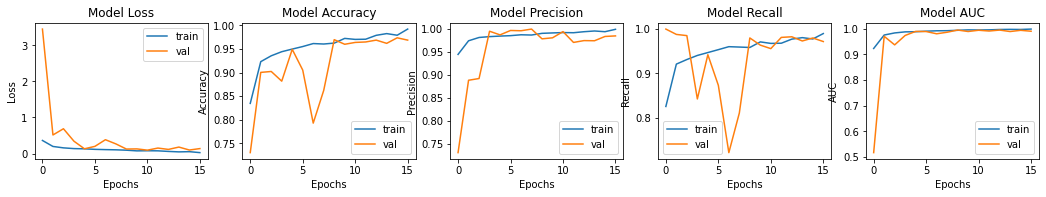

In [77]:
metrics = ["Loss", "Accuracy", "Precision", "Recall", "AUC"]
fig, axes = plt.subplots(1, 5, figsize=(18, 2.5))

for i in range(5):
    axes[i].plot(history.history[[*history.history][i]])
    axes[i].plot(history.history[[*history.history][i+5]])
    axes[i].set_title("Model {}".format(metrics[i]))
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel(metrics[i])
    axes[i].legend(['train', 'val'])

The plot suggests that we seem to have converged nicely, and further training could potentially cause us to overfit.
  
Let us load back the best epoch from our checkpoint saves:

In [78]:
model_cnn = keras.models.load_model(os.path.join(DIR, "pneumonia_cb.h5"))

## Model Evaluation

We will make a separate dataset for our test examples, notably without shuffling.

In [79]:
test_filenames = tf.convert_to_tensor(test_set_paths)
test_targets = tf.convert_to_tensor(test_target)

test_files_ds = tf.data.Dataset.from_tensor_slices((test_filenames, test_targets))

test_ds = test_files_ds.map(preprocess_image).batch(32)

In [80]:
loss, acc, prec, rec, auc = model_cnn.evaluate(test_ds) 
scores_cnn = [acc, prec, rec, auc]

20/20 [==============================] - 9s 450ms/step - loss: 0.5627 - accuracy: 0.8397 - precision: 0.8085 - recall: 0.9744 - AUC: 0.9237


Our test scores looks promising.  
  
We make a prediction on the test set and convert the probabilities into predictions so we can compare these results with our benchmark models.

In [81]:
probas_cnn = model_cnn.predict(test_ds)
preds_cnn = np.array([1 if proba > 0.5 else 0 for proba in probas_cnn])
test_labels_cnn = np.concatenate([label.numpy() for _, label in test_ds], axis=0)
test_examples_cnn = np.concatenate([data.numpy() for data, _ in test_ds])

### Visual Inspection of Results

Let us look at some of the examples our models predicted:

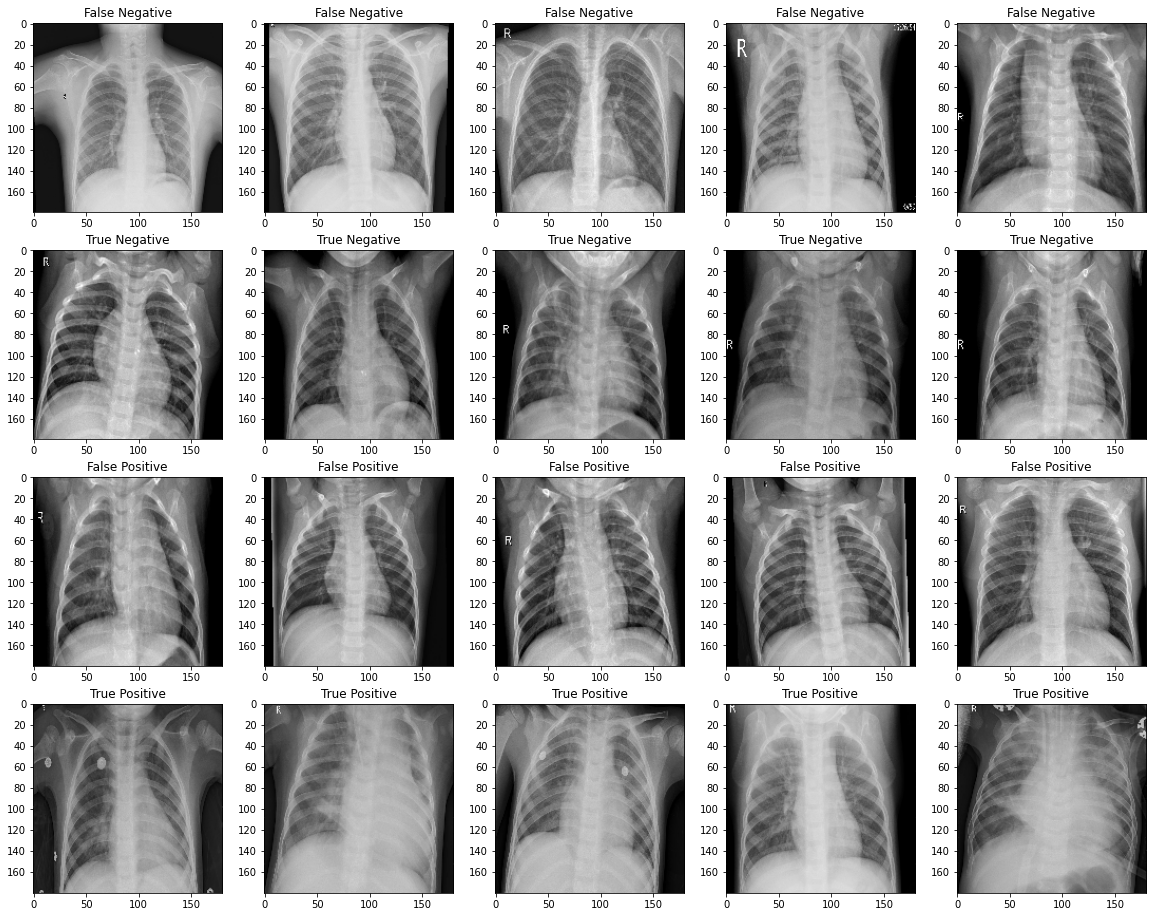

In [111]:
misclassified_idx = np.where(np.abs(preds_cnn - test_labels_cnn) == 1)[0]
correct_idx = np.where(np.abs(preds_cnn - test_labels_cnn) == 0)[0]

false_negative_idx = misclassified_idx[misclassified_idx <= 234]
false_positive_idx = misclassified_idx[misclassified_idx > 234]
true_negative_idx = correct_idx[correct_idx <= 234]
true_positive_idx = correct_idx[correct_idx > 234]

indices = [false_negative_idx, false_positive_idx,
           true_negative_idx, true_positive_idx]

index = np.concatenate([np.random.choice(idx, 5, ) for idx in indices], axis=0)
titles = (["False Negative"] * 5 + ["True Negative"] * 5 
          + ["False Positive"] * 5 + ["True Positive"] * 5)

fig, axes, = plt.subplots(4, 5, figsize=(20, 16))
for ax, idx, title in zip(axes.ravel(), index, titles):
    ax.imshow(test_examples_cnn[idx, :, :, :])
    ax.set_title(title)

This is where expert knowledge would be helpful to recognize any patterns of mistake in our model.  
  
It would seem the contrast of the xrays are worse for our false negatives compared to the true negatives, while there are no such obvious pattern regarding the false positives and true positives.

### Metrics and AUC comparison with benchmark

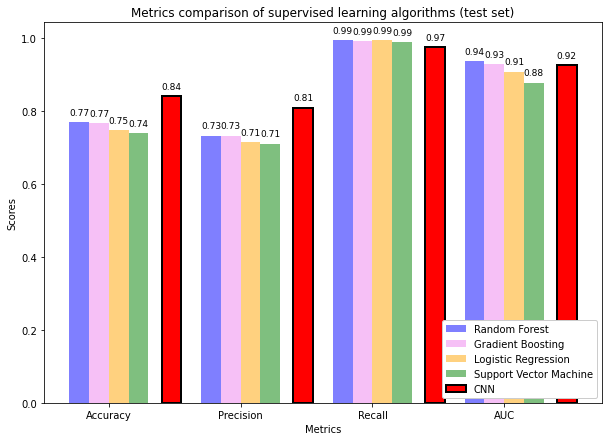

In [117]:
X = np.arange(4)

plt.figure(figsize=(10, 7))

for i in range(4):
    plt.bar(X + 0.15 * i, scores[i], color=colors[i], width=0.15, label=model_names[i], alpha=0.5)
    for j in range(4):
        plt.text((X[i] + 0.15 * j), scores[j][i] + 0.02, "{:.2f}".format(scores[j][i]), 
                 horizontalalignment='center', size=9)
        
plt.bar(X + 0.14 * 5, scores_cnn, color="red", width=0.15, label="CNN", edgecolor="black", linewidth=2)
for i in range(4):
    plt.text(X[i] + 0.14 * 5, scores_cnn[i] + 0.02, "{:.2f}".format(scores_cnn[i]),
             horizontalalignment='center', size=9)
        
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.title("Metrics comparison of supervised learning algorithms (test set)")
plt.xticks(np.arange(4) + 0.225, metric_names)
plt.legend(loc="lower right", framealpha=1)

plt.show()

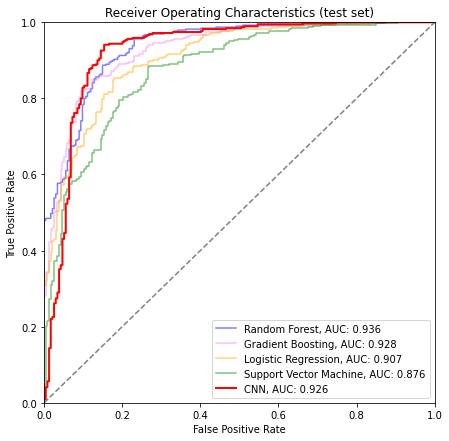

In [118]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(7,7))
plt.title("Receiver Operating Characteristics (test set)")

for i in range(4):
  fpr, tpr, threshold = roc_curve(y_test, probas[i])
  AUC = roc_auc_score(y_test, probas[i])
  lab = "{}, AUC: {:.3f}".format(model_names[i], AUC)
  plt.plot(fpr, tpr, c=colors[i], label = lab, alpha=0.5)
    
fpr, tpr, threshold = roc_curve(test_labels_cnn, probas_cnn)
AUC = roc_auc_score(test_labels_cnn, probas_cnn)
lab_cnn = "CNN, AUC: {:.3f}".format(AUC)
plt.plot(fpr, tpr, c="red", label = lab_cnn, linewidth=2)

plt.legend()
plt.plot([0, 1], [0, 1], '--', c="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Conclusion

Both in terms of training time and performance, our CNN model seem to outperform our benchmark models. Of course, the CNN model requires more time of the programmer preparing and designing the model but the significant increase in accuracy would in most cases be worth the time investment.  
  
We see that the ROC curve for our CNN model is not as flexible as some other models if we wanted to focus on one type of classification. For example, if all we cared about was to lower our false positive rate, we would prefer the Random Forest model. 

A possible way to increase our precision would be to make an ensemble a CNN model and a Random Forest model with an adjusted threshold.